<a href="https://colab.research.google.com/github/LudwigBitHoven/Monopoy_testTask/blob/main/Monopoly_testTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек, генерация датафрейма

In [182]:
import pandas as pd
import numpy as np
from random import randint, shuffle, choice
import datetime
from calendar import monthrange
import matplotlib.pyplot as plt
import seaborn as sns

In [183]:
# составим базовый словарь из которого будем делать датафрейм
keys = {
  "transaction_id": [1],
  "customer_id": [1001],
  "product_id": [2001],
  "product_category": ["Electronics"],
  "amount": [299.99],
  "date": ["2024-01-03"]
}
# построим предварительный датафрейм
test_df = pd.DataFrame.from_dict(keys)
test_df.head()

,transaction_id,customer_id,product_id,product_category,amount,date
0,1,1001,2001,Electronics,299.99,2024-01-03


In [184]:
PRODUCT_CATEGORIES = ["Electronics", "Shoes", "Crockery", "Furniture", "Dairy", "Pastry"]
DATA_DICT_TEMPLATE = {
  "transaction_id": [1],
  "customer_id": [1001],
  "product_id": [2001],
  "product_category": ["Electronics"],
  "amount": [299.99],
  "date": ["2024-01-03"]
}


class DataGenerator():
  def __init__(self, product_categories=PRODUCT_CATEGORIES, data_dict_template=DATA_DICT_TEMPLATE):
    self._product_categories = product_categories
    self._data_dict = data_dict_template

  def generate_date(self):
    # генерирует дату
    year = randint(1990, 2024)
    month = randint(1, 12)
    # monthrange возвращает пару значений: (first_week_day, days_in_month)
    days_in_month = monthrange(year, month)[1]
    day = randint(1, days_in_month)
    return f"{year}-{month}-{day}"
    # return datetime.datetime.strptime(f"{year}-{month}-{day}", "%Y-%m-%d")

  def generate_amount(self):
    # генерирует цену/количество
    price = 10 * randint(1, 100) + 9.99
    return price

  def generate_ids(self, n: int):
    # генератор id для транзакций, клиентов и продуктов
    idx_lst = [idx for idx in range(n)]
    shuffle(idx_lst)
    return idx_lst

  def generate_data(self, n: int):
    for row in range(n):
      self._data_dict["date"].append(self.generate_date())
      self._data_dict["amount"].append(self.generate_amount())
      self._data_dict["product_category"].append(choice(self._product_categories))
    self._data_dict["transaction_id"].extend(self.generate_ids(n))
    self._data_dict["customer_id"].extend([randint(1, 1000) for i in range(n)])
    self._data_dict["product_id"].extend(self.generate_ids(n))
    return self._data_dict


obj = DataGenerator()
data_dict = obj.generate_data(1000)

df = pd.DataFrame.from_dict(data_dict)
df.head(10)

,transaction_id,customer_id,product_id,product_category,amount,date
0,1,1001,2001,Electronics,299.99,2024-01-03
1,774,406,149,Furniture,849.99,2004-1-30
2,283,899,893,Crockery,299.99,1993-12-11
3,67,775,469,Shoes,909.99,2021-7-19
4,959,476,60,Furniture,529.99,2004-12-13
5,196,846,665,Crockery,939.99,2007-10-3
6,728,650,513,Shoes,489.99,1998-7-28
7,273,116,453,Shoes,649.99,2012-3-1
8,280,717,790,Electronics,929.99,2004-6-15
9,126,378,555,Dairy,619.99,2024-2-22


# Обработка датафрейма

In [185]:
"""
  Есть два способа обработать пропущенные значения: удалить их или заменить 'нулями'.
  Каждый из вариантов имеет очевидные плюсы и минусы, но кажется, что наиболее подходящий
  в большинстве случаев вариант - это первый
"""
df = df.dropna() # удаляет все строки, содержащие хотя бы один NaN

In [186]:
# преобразуем даты в datetime (код работает если все даты в столбце представлены в типе string)
df["date"] = df["date"].apply(lambda date: datetime.datetime.strptime(date, "%Y-%m-%d"))
df.head()

,transaction_id,customer_id,product_id,product_category,amount,date
0,1,1001,2001,Electronics,299.99,2024-01-03
1,774,406,149,Furniture,849.99,2004-01-30
2,283,899,893,Crockery,299.99,1993-12-11
3,67,775,469,Shoes,909.99,2021-07-19
4,959,476,60,Furniture,529.99,2004-12-13


# Анализ данных

## Количество транзакций и пользователей
Посчитаем количество транзакций двумя способами: как количество уникальных значений в столбце transaction_id и как размер датафрейма.

In [187]:
print(f"Количество транзакций по размеру датафрейма: {df.shape[0]}\n")
print(f"Количество уникальных записей по столбцам:\n{df.nunique()}")

Количество транзакций по размеру датафрейма: 1001

Количество уникальных записей по столбцам:
transaction_id      1000
customer_id          617
product_id          1001
product_category       6
amount               100
date                 955
dtype: int64


Датафрейм имеет 1000 уникальных значений transaction_id, но 1001 запись. Так произошло потому, что DATA_DICT_TEMPLATE уже имел изначально одну запись с transaction_id равным 1 и при генерации id=1 дублировались в двух записях. Выведем эти значения и удалим дублированную запись, чтобы количество записей совпадали:

In [188]:
df[df["transaction_id"] == 1]

,transaction_id,customer_id,product_id,product_category,amount,date
0,1,1001,2001,Electronics,299.99,2024-01-03
353,1,794,636,Crockery,179.99,2018-01-07


In [189]:
df = df.drop(index=353)
df.nunique()

transaction_id      1000
customer_id          617
product_id          1000
product_category       6
amount               100
date                 954
dtype: int64

Итого у нас 619 уникальных клиентов и 1000 уникальных транзакций

## Топ-5 категорий по доходу

In [190]:
# составляем сводную таблицу
top_categories = pd.pivot_table(df, values="amount", index="product_category", aggfunc="sum")
# сортируем по суммам
top_categories = top_categories.sort_values(by="amount", ascending=False)
# выводим результат
top_categories.head()

,amount
product_category,
Pastry,95378.21
Crockery,93278.18
Shoes,88938.17
Electronics,82068.42
Furniture,79288.38


In [191]:
# составляем сводную таблицу
category_mean_amount = pd.pivot_table(df, values="amount", index="product_category", aggfunc="mean")
# выводим результат
category_mean_amount

,amount
product_category,
Crockery,512.517473
Dairy,473.372353
Electronics,519.420380
Furniture,489.434444
Pastry,532.839162
Shoes,486.000929


# Визуализация данных

## Распределение транзакций по месяцам

In [192]:
per_month_distrubtion = pd.pivot_table(
    df,
    index=df["date"].dt.month, # группируем по месяцам
    values="transaction_id",
    aggfunc="count" # считаем количество транзакций
  )
per_month_distrubtion

,transaction_id
date,
1,85
2,67
3,84
4,87
5,94
6,93
7,79
8,83
9,94


Text(0, 0.5, 'Количество транзакций')

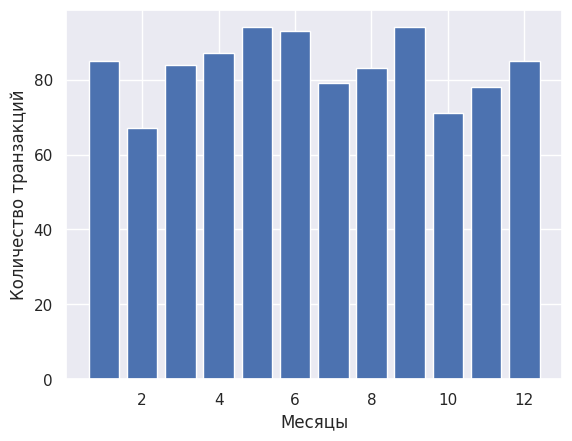

In [193]:
sns.set_theme()
plt.bar(per_month_distrubtion.index, per_month_distrubtion["transaction_id"])
plt.xlabel("Месяцы")
plt.ylabel("Количество транзакций")

# Доли дохода по категориям товара

In [194]:
category_revenue = pd.pivot_table(
    df,
    index="product_category", # группируем по типу продукции
    values="amount",
    aggfunc="sum" # считаем сумму по каждой категории
  )
category_revenue

,amount
product_category,
Crockery,93278.18
Dairy,64378.64
Electronics,82068.42
Furniture,79288.38
Pastry,95378.21
Shoes,88938.17


In [195]:
# Переведем в доли, это не изменит результат в круговой диаграмме, но может быть использовано в дальнейшем
total_sum = np.sum(df["amount"])
category_revenue["amount"] = category_revenue["amount"].apply(lambda amount: amount / total_sum)
category_revenue

,amount
product_category,
Crockery,0.185322
Dairy,0.127905
Electronics,0.163051
Furniture,0.157528
Pastry,0.189494
Shoes,0.176700


([<matplotlib.patches.Wedge at 0x7c7cf595b940>,
 [Text(0.9187764713737008, 0.6048551856850459, 'Crockery'),
  Text(0.005011963404580898, 1.099988581860208, 'Dairy'),
  Text(-0.868123186827551, 0.6755458034007593, 'Electronics'),
  Text(-1.034869819791309, -0.37288665313350067, 'Furniture'),
  Text(-0.14778083752054683, -1.090027900588662, 'Pastry'),
  Text(0.9348221319844278, -0.5797478603255809, 'Shoes')])

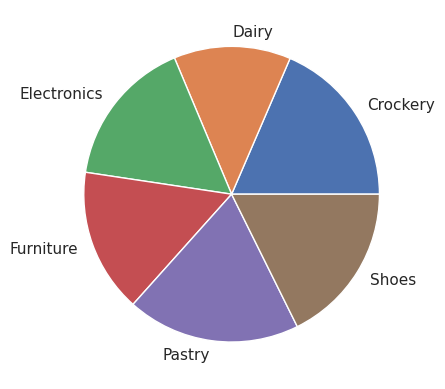

In [196]:
plt.pie(category_revenue["amount"], labels=category_revenue.index)

Распределение у Random слишком равное и красивое, что делает круговую диаграмму не очень информативной

# Подготовка данных для машинного обучения

In [221]:
# сделаем копию
df_copy = df.copy()
# создадим столбец year_month
df_copy["date"] = df_copy["date"].apply(lambda date: f"{date.year}-{date.month}")
df_copy["date"].name = "year_month"
# почему-то не получилось с обычным rename, использую альтернативный способ:
df_copy.columns = ["transaction_id", "customer_id", "product_id",	"product_category",	"amount",	"year_month"]
df_copy

,transaction_id,customer_id,product_id,product_category,amount,year_month
0,1,1001,2001,Electronics,299.99,2024-1
1,774,406,149,Furniture,849.99,2004-1
2,283,899,893,Crockery,299.99,1993-12
3,67,775,469,Shoes,909.99,2021-7
4,959,476,60,Furniture,529.99,2004-12
...,...,...,...,...,...,...
996,723,485,441,Furniture,339.99,2015-9
997,714,93,362,Pastry,629.99,2020-12
998,108,15,224,Electronics,679.99,1998-11
999,256,823,10,Shoes,59.99,1998-12


In [239]:
def monthly_revenue_per_customer():
  # составим сводную таблицу
  client_pivot_table = pd.pivot_table(
    df_copy,
    index=["year_month", "customer_id"], # группируем по месяцам
    values="amount",
    fill_value=0,
    aggfunc="sum" # считаем количество транзакций
  )
  # переимениуем индексы
  client_pivot_table.index.names = ["year_month", "customer_id"]
  return client_pivot_table

ddf = monthly_revenue_per_customer()
ddf

amount
year_month customer_id        
1990-1     434          209.99
           529          149.99
           846          419.99
1990-10    253          339.99
           339          549.99
...                        ...
2024-8     258           19.99
           749          879.99
2024-9     348          809.99
           557          649.99
           767          179.99

[998 rows x 1 columns]

In [240]:
ddf.to_csv("monthly_revenue_per_customer.csv")
df.to_csv("transactions.csv")